# POLI 175 - Lecture 12

## KNN (some more) and Non-linearity

## Class Examples

1. Education expenditure dataset

1. Pinochet voting dataset

Let us load them all:

In [1]:
## Packages Here
using DataFrames
using MLJ, MLJIteration
import MLJLinearModels, MLJBase, MLJModels
import MultivariateStats, MLJMultivariateStatsInterface
import CSV, Plots, GLM, StatsBase, Random
import LaTeXStrings, StatsPlots, Lowess, Gadfly, RegressionTables
import CovarianceMatrices, Econometrics, LinearAlgebra, MixedModelsExtras
import Missings, StatsAPI, FreqTables, EvalMetrics
import NearestNeighborModels

# Adapted from @xiaodaigh: https://github.com/xiaodaigh/DataConvenience.jl
function onehot!(df::AbstractDataFrame, 
        col, cate = sort(unique(df[!, col])); 
        outnames = Symbol.(col, :_, cate))
    transform!(df, @. col => ByRow(isequal(cate)) .=> outnames)
end

onehot! (generic function with 2 methods)

## Class Examples

In [2]:
## Loading the data
chile = CSV.read(
    download("https://raw.githubusercontent.com/umbertomig/POLI175julia/main/data/chilesurvey.csv"), 
    DataFrame,
    missingstring = ["NA"]
); dropmissing!(chile)
chile.voteyes = ifelse.(chile.vote .== "Y", 1, 0)

# One-hot encoding (we will learn a better way to do it later)
onehot!(chile, :region);
onehot!(chile, :education);
onehot!(chile, :sex);

# Drop reference categories
select!(chile, Not(:region, :income, :population, :sex, :education, :region_C, :education_P, :sex_M))

# Checking
first(chile, 3)

Row,age,statusquo,vote,voteyes,region_M,region_N,region_S,region_SA,education_PS,education_S,sex_F
,Int64,Float64,String1,Int64,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,65,1.0082,Y,1,false,true,false,false,false,false,false
2,29,-1.29617,N,0,false,true,false,false,true,false,false
3,38,1.23072,Y,1,false,true,false,false,false,false,true


## Class Examples

In [3]:
## Education Expenditure Dataset
educ = CSV.read(download("https://raw.githubusercontent.com/umbertomig/POLI175julia/main/data/educexp.csv"), DataFrame)

# Processing
educ.educ_log = log.(educ.education);
educ.income_log = log.(educ.income)
educ.urban_log = log.(educ.urban)
educ.young_log = log.(educ.young)

# Checking
first(educ, 3)

Row,education,income,young,urban,states,educ_log,income_log,urban_log,young_log
,Int64,Int64,Float64,Int64,String3,Float64,Float64,Float64,Float64
1,189,2824,350.7,508,ME,5.24175,7.94591,6.23048,5.85993
2,169,3259,345.9,564,NH,5.1299,8.08918,6.33505,5.84615
3,230,3072,348.5,322,VT,5.43808,8.03008,5.77455,5.85364


## Class Examples

Now, let's go crazy: Add lots of polynomials to our model!

In [4]:
## Education Expenditure Dataset
educ.income_log_square = educ.income_log .^ 2
educ.urban_log_square = educ.urban_log .^ 2
educ.young_log_square = educ.young_log .^ 2
educ.income_log_cube = educ.income_log .^ 3
educ.urban_log_cube = educ.urban_log .^ 3
educ.young_log_cube = educ.young_log .^ 3
educ.income_log_4th = educ.income_log .^ 4
educ.urban_log_4th = educ.urban_log .^ 4
educ.young_log_4th = educ.young_log .^ 4

educ_y, educ_X = unpack(
    educ[:, Not(:states)],
    ==(:educ_log);
    :educ_log => Continuous, 
    :income_log => Continuous,
    :urban_log => Continuous,
    :young_log => Continuous,
    :income_log_square => Continuous,
    :urban_log_square => Continuous,
    :young_log_square => Continuous,
    :income_log_cube => Continuous,
    :urban_log_cube => Continuous,
    :young_log_cube => Continuous,
    :income_log_4th => Continuous,
    :urban_log_4th => Continuous,
    :young_log_4th => Continuous,
);    

# Checking
first(educ_X, 3)

Row,education,income,young,urban,income_log,urban_log,young_log,income_log_square,urban_log_square,young_log_square,income_log_cube,urban_log_cube,young_log_cube,income_log_4th,urban_log_4th,young_log_4th
,Int64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,189,2824,350.7,508,7.94591,6.23048,5.85993,63.1375,38.8189,34.3388,501.685,241.86,201.223,3986.34,1506.91,1179.15
2,169,3259,345.9,564,8.08918,6.33505,5.84615,65.4348,40.1329,34.1775,529.313,254.244,199.807,4281.71,1610.65,1168.1
3,230,3072,348.5,322,8.03008,5.77455,5.85364,64.4823,33.3454,34.2651,517.798,192.555,200.575,4157.96,1111.92,1174.1


## Classification

### K-Nearest Neighbors Classifier

Little detour back to talk about a good algorithm for classification (also very intuitive).

Given an integer $K$, and a test observation, it says that:

$$ \mathbb{P}(Y = j| X = x_0) \ = \ \dfrac{1}{K}\sum_{i \in N_0} I(y_i = j) $$

Meaning: classify the observation based on the class of the closest $K$ obs:
- The one more frequent is the winner.
    
*Closest*: Idea of a metric.

## Classification

### K-Nearest Neighbors Classifier

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/knn1.png?raw=true)

## Classification

### K-Nearest Neighbors Classifier

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/knn2.png?raw=true)

## Classification

### K-Nearest Neighbors Classifier

We are going to classify all the types of votes we have in the dataset.

In [5]:
y, X = unpack(
    chile,
    ==(:vote),
    !=(:voteyes),
    c -> true;
    :vote         => Multiclass,
    :income_log   => Continuous,
    :pop_log      => Continuous,
    :age          => Continuous,
    :statusquo    => Continuous,
    :region_M     => Multiclass,
    :region_N     => Multiclass,
    :region_S     => Multiclass,
    :region_SA    => Multiclass,
    :sex_F        => Multiclass,
    :education_S  => Multiclass,
    :education_PS => Multiclass,
);

## Classification

### K-Nearest Neighbors Classifier

In [12]:
FreqTables.freqtable(y)

4-element Named Vector{Int64}
Dim1  │ 
──────┼────
A     │ 177
N     │ 867
U     │ 551
Y     │ 836

In [7]:
first(X, 3)

Row,age,statusquo,region_M,region_N,region_S,region_SA,education_PS,education_S,sex_F
,Float64,Float64,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…
1,65.0,1.0082,false,true,false,false,false,false,false
2,29.0,-1.29617,false,true,false,false,true,false,false
3,38.0,1.23072,false,true,false,false,false,false,true


## Classification

### K-Nearest Neighbors Classifier

The first thing we do is to perform a train-test split.

```julia
(X_train, X_test), (y_train, y_test) = partition(
    (X, y),        ## Data (features, targets)
    0.8,           ## Fraction of the data (80% training)
    rng = 8574085, ## Random Seed
    multi = true,  ## multi: adding features and targets same object
    stratify = y   ## Stratify by the target (good to aviod having imbalances)
);
```

In [8]:
## Creating the train-test split:
(X_train, X_test), (y_train, y_test) = partition((X, y), 0.8, rng = 8574085, multi=true, stratify = y)

((1946×9 DataFrame
  Row │ age      statusquo  region_M  region_N  region_S  region_SA  education ⋯
      │ Float64  Float64    Cat…      Cat…      Cat…      Cat…       Cat…      ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    22.0   -0.80408  false     false     false     false      false     ⋯
    2 │    58.0   -1.29617  false     false     false     true       true
    3 │    44.0   -1.03566  false     false     false     false      false
    4 │    58.0   -1.29617  false     false     true      false      false
    5 │    45.0   -0.41564  false     false     true      false      false     ⋯
    6 │    39.0    0.75719  false     true      false     false      false
    7 │    28.0    0.13858  false     false     true      false      false
    8 │    44.0    0.47231  false     false     false     true       true
    9 │    63.0   -0.84928  false     false     false     false      false     ⋯
   10 │    62.0    1.12272  false     false    

## Classification

### K-Nearest Neighbors Classifier

Cross-Validating Procedure:

```julia
# 3-Fold CV
cv3 = CV(
    nfolds = 3,  ## Number of cross-validating folds
    rng = 45321  ## Random seed
);
```

In [9]:
# 3-Fold CV
cv3 = CV(
    nfolds = 3,  ## Number of cross-validating folds
    rng = 45321  ## Random seed
);

## Classification

### K-Nearest Neighbors Classifier

Now, let us fit a 10-Nearest Neighborhood model. It takes the 10 observations around each point, and classify it based on these neighbors' classes.

```julia
## Instantiate the Model
knn = NearestNeighborModels.KNNClassifier(K = 10) 

## Evaluate the Model
evaluate(knn,                      ## Model
    X_train,                       ## Training features set
    y_train,                       ## Training target set
    resampling = cv3,              ## Resampling strategy (in this case, 3-Fold CV
    measure = [accuracy, f1score], ## Measures
    verbosity = 0
)
```

In [10]:
## Instantiate the Model
knn = NearestNeighborModels.KNNClassifier(K = 10) 

## Evaluate the Model
evaluate(knn, X_train, y_train, resampling = cv3, measure = [accuracy], verbosity = 0)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc NearestNeighborModels.KNNClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}}}, AbstractVector{Multiclass{4}}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}}, Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVecto

PerformanceEvaluation object with these fields:
  model, measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows, resampling, repeats
Extract:
┌────────────┬──────────────┬─────────────┬─────────┬───────────────────────┐
│ measure    │ operation    │ measurement │ 1.96*SE │ per_fold              │
├────────────┼──────────────┼─────────────┼─────────┼───────────────────────┤
│ Accuracy() │ predict_mode │ 0.63        │ 0.0349  │ [0.606, 0.629, 0.656] │
└────────────┴──────────────┴─────────────┴─────────┴───────────────────────┘


## Classification

### K-Nearest Neighbors Classifier

To check the accuracy:

```julia
## Fit a machine on the training set
mach1 = machine(knn, X_train, y_train);
MLJ.fit!(mach1);

## Predict results on the testing set
ypred_mode = MLJ.predict_mode(mach1, X_test);

## Check accuracy in the testing set
accuracy(y_test, ypred_mode)
```

This strategy is the *training-validation-testing* strategy.

In [13]:
mach1 = machine(knn, X_train, y_train);
MLJ.fit!(mach1);

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc NearestNeighborModels.KNNClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}}}, AbstractVector{Multiclass{4}}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}}, Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVecto

In [14]:
# Accuracy
ypred_mode = MLJ.predict_mode(mach1, X_test);
accuracy(y_test, ypred_mode)

0.6474226804123712

## Classification

### K-Nearest Neighbors Classifier

And the Testing-Set confusion matrix now looks interesting:

In [15]:
confusion_matrix(ypred_mode, y_test) 

          ┌───────────────┐
          │ Ground Truth  │
┌─────────┼───┬───┬───┬───┤
│Predicted│ A │ N │ U │ Y │
├─────────┼───┼───┼───┼───┤
│    A    │ 0 │ 1 │ 4 │ 0 │
├─────────┼───┼───┼───┼───┤
│    N    │14 │152│36 │19 │
├─────────┼───┼───┼───┼───┤
│    U    │ 8 │10 │32 │18 │
├─────────┼───┼───┼───┼───┤
│    Y    │13 │10 │38 │130│
└─────────┴───┴───┴───┴───┘


## Classification

### K-Nearest Neighbors Classifier

**Grid Search**

One last thing we do is to search for the best $K$ that maximizes (minimizes) some measure of interest. This is called Grid-Search.

1. Instantiate the model
1. Create the range of parameters to be searched
1. Instantiate the self-tuning model (this creates a model that searches for the best hyperparameters automatically)
1. Fit the machine

Let us run this step-by-step.

In [16]:
# Instantiate tuning KNN model
knn = NearestNeighborModels.KNNClassifier()

KNNClassifier(
  K = 5, 
  algorithm = :kdtree, 
  metric = Distances.Euclidean(0.0), 
  leafsize = 10, 
  reorder = true, 
  weights = NearestNeighborModels.Uniform())

## Classification

### K-Nearest Neighbors Classifier

**Grid Search**

In [17]:
# Instantiate the range of K for our search 5 to 55
Ktune = range(knn, :K, lower=5, upper=55)

NumericRange(5 ≤ K ≤ 55; origin=30.0, unit=25.0)

## Classification

### K-Nearest Neighbors Classifier

**Grid Search**

In [18]:
# Instantiate the Self-Tuning Model
self_tuning_knn = TunedModel(
    model = knn,            ## Model
    resampling = cv3,       ## Resampling strategy (use our 3-Fold CV)
    tuning = Grid(          ## Tuning method
        resolution = 25,       ## Tuning resolution (how to divide the range of searched parameters)
        rng = 598745978        ## Random seed
    ),
    range = Ktune,          ## Hyperparameter to be tuned
    measure = accuracy      ## Measure to focus when tuning the hyperparameter
)

ProbabilisticTunedModel(
  model = KNNClassifier(
        K = 5, 
        algorithm = :kdtree, 
        metric = Distances.Euclidean(0.0), 
        leafsize = 10, 
        reorder = true, 
        weights = NearestNeighborModels.Uniform()), 
  tuning = Grid(
        goal = nothing, 
        resolution = 25, 
        shuffle = true, 
        rng = Random.MersenneTwister(598745978)), 
  resampling = CV(
        nfolds = 3, 
        shuffle = true, 
        rng = Random.MersenneTwister(45321, (0, 3006, 2004, 720))), 
  measure = Accuracy(), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  range = NumericRange(5 ≤ K ≤ 55; origin=30.0, unit=25.0), 
  selection_heuristic = MLJTuning.NaiveSelection(nothing), 
  train_best = true, 
  repeats = 1, 
  n = nothing, 
  acceleration = CPU1{Nothing}(nothing), 
  acceleration_resampling = CPU1{Nothing}(nothing), 
  check_measure = true, 
  cache = true)

## Classification

### K-Nearest Neighbors Classifier

**Grid Search**

In [19]:
# Fitting the self-tuning machine
mach2 = machine(self_tuning_knn, X_train, y_train, scitype_check_level = 0);
MLJ.fit!(mach2);

[ Info: Training machine(ProbabilisticTunedModel(model = KNNClassifier(K = 5, …), …), …).
[ Info: Attempting to evaluate 25 models.
Evaluating over 25 metamodels:   0%[>                        ]  ETA: N/A┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc NearestNeighborModels.KNNClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2

## Classification

### K-Nearest Neighbors Classifier

**Grid Search**

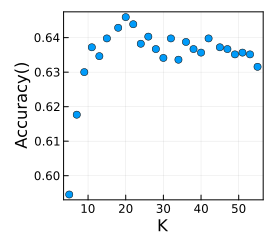

In [20]:
# The plot
Plots.plot(mach2)

## Classification

### K-Nearest Neighbors Classifier

**Grid Search**

In [21]:
# Best Model parameters (not needed)
fitted_params(mach2).best_model

KNNClassifier(
  K = 20, 
  algorithm = :kdtree, 
  metric = Distances.Euclidean(0.0), 
  leafsize = 10, 
  reorder = true, 
  weights = NearestNeighborModels.Uniform())

## Classification

### K-Nearest Neighbors Classifier

**Grid Search**

In [22]:
# Predicted accuracy of best model on testing set
ypred_mode2 = MLJ.predict_mode(mach2, X_test);
accuracy(y_test, ypred_mode2)

0.6577319587628866

In [23]:
confusion_matrix(ypred_mode2, y_test) 

          ┌───────────────┐
          │ Ground Truth  │
┌─────────┼───┬───┬───┬───┤
│Predicted│ A │ N │ U │ Y │
├─────────┼───┼───┼───┼───┤
│    A    │ 0 │ 0 │ 0 │ 0 │
├─────────┼───┼───┼───┼───┤
│    N    │16 │156│43 │15 │
├─────────┼───┼───┼───┼───┤
│    U    │ 8 │ 6 │28 │17 │
├─────────┼───┼───┼───┼───┤
│    Y    │11 │11 │39 │135│
└─────────┴───┴───┴───┴───┘


## Beyond Linearity

## Beyond Linearity

So far, we have focused on linear models.

Most of the time, linear approximations are excellent:
- Easy to interpret
- Easy to run

And all the GLM flavors afford lots of flexibility regarding how we deal with data.

In the following two lectures, we relax the linearity assumption but keep it as simple as possible.

## Polynomial Regression

Expands the default model ($y_i = \beta_0 + \beta_1x_i + \varepsilon_i$) to consider a polynomial $d$:

$$ y_i = \beta_0 + \beta_1x_i + \beta_2x_i^2 +\cdots + \beta_dx_i^d + \varepsilon_i $$
                     
Lots of flexibility here, but we seldom use $d>4$ because then it gets *excessively* flexible.

Prediction very straightforward:

$$ \hat{f}(x_0) = \hat{\beta}_0 + \hat{\beta}_1x_0 + \hat{\beta}_2x_0^2 +\cdots + \hat{\beta}_dx_0^d $$

## Polynomial Regression

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/polyreg1.png?raw=true)

## Polynomial Regression

Let us try to explain `education` expenditure using per capita `income`.

In [ ]:
# Checking
first(educ, 3)

## Polynomial Regression

Let us try to explain `education` expenditure using per capita `income`.

In [ ]:
educaux = educ[:, ["education", "income"]];
educaux.income2 = educaux.income .^ 2;
educaux.income3 = educaux.income .^ 3;
educaux.income4 = educaux.income .^ 4;
educaux.income5 = educaux.income .^ 5;
educaux.income6 = educaux.income .^ 6;

In [ ]:
y, X = unpack(
    educaux, ## Variables we need
    ==(:education);                        ## Target (all else features...)
    :education   => Continuous,            ## Var types
    :income      => Continuous,
    :income2     => Continuous,
    :income3     => Continuous,
    :income4     => Continuous,
    :income5     => Continuous,
    :income6     => Continuous,
);

## Polynomial Regression

In [ ]:
linreg = MLJLinearModels.LinearRegressor()

In [ ]:
# 3-Fold CV
cv3 = CV(
    nfolds = 3,  ## Number of cross-validating folds
    rng = 45321  ## Random seed
);

## Polynomial Regression

In [ ]:
## Evaluate the Model
vars = Vector{String}()
for i in ("income", "income2", "income3", "income4", "income5", "income6")
    push!(vars, i)
    println(
        evaluate(linreg,                   ## Model
            X[:, vars],                    ## Training features set
            y,                             ## Training target set
            resampling = cv3,              ## Resampling strategy (in this case, 3-Fold CV)
            measure = [l2, rmse],          ## Measures
            verbosity = 0)
    )
end

I view the linear regression as the best for this relationship.

## Polynomial Regression

**Your turn:** Do the same with the proportion of young.

In [ ]:
# Your code here

## Basis Functions

Family of transformations $b_i(X)$ such that, instead of fitting a regression model in $X$, we fit:

$$ y_i \ = \ \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + \cdots + \beta_kb_k(x_i) + \varepsilon_i $$

In this sense:
- Polynomial Regression: $b_j(x_i) = x_i^j$
- Constant-piecewise Regression: $b_j(x_i) = C_j(x_i) = I(c_j \leq X < c_{j+1})$
    
Meaning: they are cases of a broader set of basis functions.

## Basis Functions

Cases:

- [Piecewise Constant Regression](https://en.wikipedia.org/wiki/Step_function)
- [Fourier series](https://en.wikipedia.org/wiki/Fourier_series)
- [Splines](https://en.wikipedia.org/wiki/Spline_(mathematics))
- [GAMs](https://en.wikipedia.org/wiki/Generalized_additive_model)
    
We are going to study a few of these in the next lecture.

# Questions?

# See you next class
